In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

In [16]:
# read in the sparse dataset
dataset = pd.read_csv(
		'../data/run-of-river_production_load_sparse.csv', 
		dtype=np.float32,
		converters={
			"Date_Time": pd.to_datetime,
			"Date": pd.to_datetime
    })

dataset['epochdate'] = dataset['Date_Time'].map(pd.Timestamp.timestamp).astype(np.float32)

/tmp/ipykernel_13113/1439761765.py:1: ParserWarning: Both a converter and dtype were specified for column Date_Time - only the converter will be used.
  dataset = pd.read_csv(
/tmp/ipykernel_13113/1439761765.py:1: ParserWarning: Both a converter and dtype were specified for column Date - only the converter will be used.
  dataset = pd.read_csv(


In [93]:
# load the PowerEX predictions
predictions = pd.read_csv(
		'../data/mve_predictions_hourly_2022.csv', 
		dtype=np.float32,
		converters={
			"Date_Time": pd.to_datetime
    })

/tmp/ipykernel_13113/576220962.py:1: ParserWarning: Both a converter and dtype were specified for column Date_Time - only the converter will be used.
  predictions = pd.read_csv(


In [ ]:
# import the model torch.nn.Module
from all_S2S_models import S2S_BA_Model

In [115]:
# load the trained weights into the model
checkpoint = torch.load('models/MODEL_w:__seed=0_cell_type=lstm_attention_model=BA_la_method=none_T=336_N=48_bs=128_hs=12', map_location=torch.device('cpu'))
model = S2S_BA_Model('lstm', 44, 12, False)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [118]:
# parameters for the example
start_index = 19400
window_source_size = 168
window_target_size = 48
dataset_norm = dataset.drop(columns=['Date','Date_Time']).values
dataset_norm = (dataset_norm - dataset_norm.mean(0)) / dataset_norm.std(0)

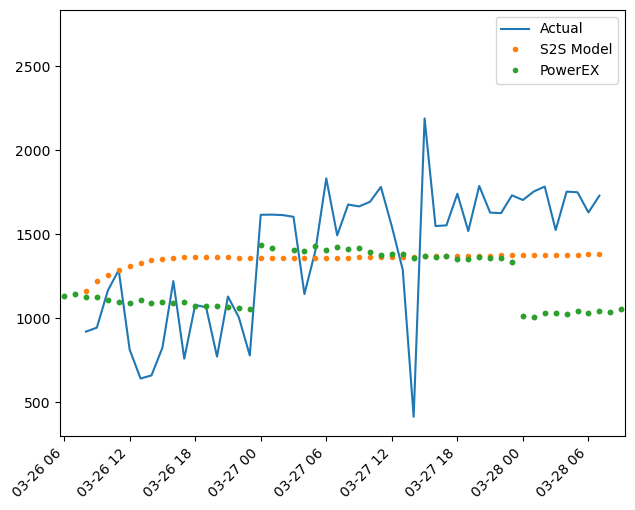

In [120]:
# retrieve range of dates for these indices
dates = dataset['Date_Time'][start_index+window_source_size:start_index+window_source_size+window_target_size]

# create the prediction (note the names of the functions may differ for your model)
pred = model.predict(*model.consume(torch.from_numpy(np.array([dataset_norm[start_index:start_index+window_source_size, :]]))), window_target_size).detach().numpy().flatten()

# plot
plt.plot(dates, dataset_norm[start_index+window_source_size:start_index+window_source_size+window_target_size, 0] * dataset['Value'].std() + dataset['Value'].mean(), label='Actual')
plt.plot(dates, pred * dataset['Value'].std() + dataset['Value'].mean(), '.', label='S2S Model')
xlim = plt.xlim()
plt.plot(predictions['Date_Time'], predictions['prediction'], '.', label='PowerEX')
plt.xlim(xlim)
plt.legend()
plt.gcf().tight_layout()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right');